
Finetuning Torchvision Models
=============================
* tutorial: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
* models: https://pytorch.org/vision/stable/models.html
* datasets: https://pytorch.org/vision/stable/datasets.html


transfer learning: https://cs231n.github.io/transfer-learning and https://ruder.io/transfer-learning



todo:
* save weights after training
    https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
    
* load weights for inference
    https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

* infer on test dataset and give some insights

* use ADAM or ADAMW instead of SGD
    https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/

* try > 224
    https://discuss.pytorch.org/t/transfer-learning-usage-with-different-input-size/20744/6



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


In [2]:
# Helper Functions
from libs.model_definitions import initialize_model
from libs.train_model import train_model

Settings
----------------

In [3]:
# data directory with [train, val, test] dirs
data_dir = "./dataset"

# number of data loader workers
dloader_workers = 4

# Number of classes in the dataset
num_classes = 4   # TODO: len(image_datasets['train'].classes)


model_list =    ["resnet18", "resnet50", "alexnet", "vgg11_bn", "squeezenet", "densenet121", "inception_v3", "mobilenet_v2", 
                "mobilenet_v3_large", "regnet_y_16gf", "efficientnet_v2_s", "efficientnet_v2_m", "convnext_base", "swin_v2_b"]

model_name = "efficientnet_v2_m"

checkpoint_path = "checkpoint/model.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 12

learning_rate = 1e-4

# train all layers or just head layer
train_deep = True


# check if model_name exists
if not model_name in model_list:
    print(f"ERROR: model {model_name} unknown!")


Helper Functions
----------------






In [4]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, train_deep)

# print(model_ft)


Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dloader_workers) for x in ['train', 'val']}


class_names = image_datasets['train'].classes

Initializing Datasets and Dataloaders...


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                img = inputs.cpu().data[j] / 2
                img = img.swapaxes(0, 1)
                img = img.swapaxes(1, 2)

                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``train_deep=False`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [7]:
# Send the model to GPU if possible
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if not train_deep:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, device=device)

Epoch 0/11
----------
train Loss: 0.7055 Acc: 0.7740
val Loss: 0.1862 Acc: 0.9399

Epoch 1/11
----------
train Loss: 0.2024 Acc: 0.9400
val Loss: 0.1151 Acc: 0.9657

Epoch 2/11
----------
train Loss: 0.1985 Acc: 0.9300
val Loss: 0.1144 Acc: 0.9785

Epoch 3/11
----------
train Loss: 0.1262 Acc: 0.9540
val Loss: 0.1210 Acc: 0.9571

Epoch 4/11
----------
train Loss: 0.1089 Acc: 0.9660
val Loss: 0.1235 Acc: 0.9614

Epoch 5/11
----------
train Loss: 0.1398 Acc: 0.9500
val Loss: 0.0964 Acc: 0.9742

Epoch 6/11
----------
train Loss: 0.1383 Acc: 0.9560
val Loss: 0.1026 Acc: 0.9571

Epoch 7/11
----------
train Loss: 0.0587 Acc: 0.9820
val Loss: 0.1729 Acc: 0.9485

Epoch 8/11
----------
train Loss: 0.0509 Acc: 0.9840
val Loss: 0.1293 Acc: 0.9742

Epoch 9/11
----------
train Loss: 0.0695 Acc: 0.9800
val Loss: 0.1902 Acc: 0.9485

Epoch 10/11
----------
train Loss: 0.0611 Acc: 0.9820
val Loss: 0.1273 Acc: 0.9657

Epoch 11/11
----------
train Loss: 0.0550 Acc: 0.9840
val Loss: 0.1058 Acc: 0.9700

Tr

In [9]:
print(float(hist[-1]))

0.9699570815450643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

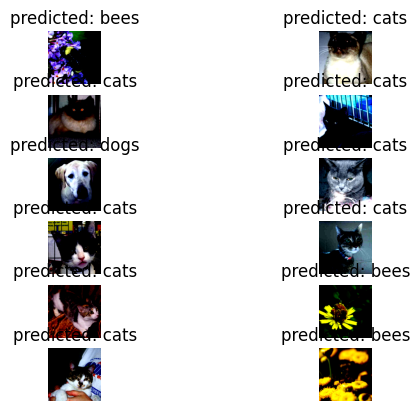

In [10]:
visualize_model(model_ft)

### Save Checkpoint
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

In [11]:
# EPOCH = num_epochs  # TODO: current epoch / epoch of best val acc
# LOSS = 0.4          # TODO read from hist
#
# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model_ft.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict(),
#             'loss': LOSS,
#             }, checkpoint_path)


torch.save(model_ft, checkpoint_path)

### Load Checkpoint

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# # Remember to first initialize the model and optimizer, then load the dictionary locally.
# model, input_size = initialize_model(model_name, num_classes, train_deep)
# model = model.to(torch.device(device))

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


model = torch.load(checkpoint_path)
model = model.to(torch.device(device))

# set dropout and batch normalization layers to evaluation mode before running inference
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
testset = datasets.ImageFolder(os.path.join(data_dir, "test"), test_transform)
test_loader = torch.utils.data.DataLoader(testset,batch_size = 64,shuffle=True)


test_acc = 0.0

for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)

        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_acc += torch.mean(correct.float())
        
print('Accuracy of the network on {} test images: {}%'.format(len(testset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 80 test images: 96.09%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

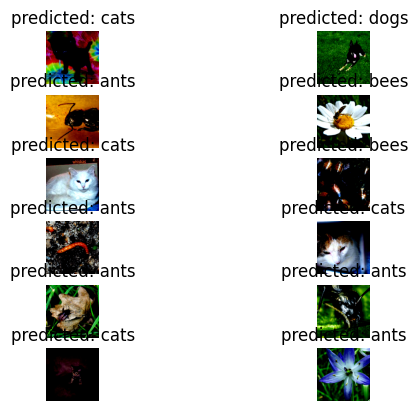

In [14]:
visualize_model(model)